<hr>
<h1> A Proof-of-Concept for an Automatic MoonBoard Route Grader </h1> 
<hr>
<h5> This notebook implements the full datascience pipeline, including: </h5> 
<ul>
    <li>JSON data collection using an automatic webscraper and an identified hidden API</li>
    <li>
        Automated image collection using Apple's 
        <a href="https://support.apple.com/en-om/guide/automator/welcome/mac" style="color: #d1a807">Automator</a>
        and
        <a href="https://developer.apple.com/library/archive/documentation/AppleScript/Conceptual/AppleScriptLangGuide/introduction/ASLR_intro.html" style="color: #d1a807">AppleScript</a>    
    </li>
    <li>Creating a multi-stage pipeline to automatically process the obtained images</li>
    <li>Verifying the extraction accuracy using the web-scraped dataset and an additional image set</li>
    <li>Exploratory Data Analysis on the collected dataset(s)</li>
    <li>Training a model to make predictions based on the data</li>

</ul>


<hr>
<h2><b> Introduction </b></h2>
Every since the recent Covid-19 pandemic, I have been spending much of my free time rock climbing. Unfortunately, as a full-time student, I often don't find the time to go outside and climb in the mountains. A group of my fellow students feel the same way, and have personally obtained approval from the university to build a small rock climbing gym on campus. Inside this gym is the 2016 
<a href="https://www.moonboard.com/" style="color: #d1a807" > MoonBoard </a>.


<h4><b>What is a MoonBoard?</b></h4>

  <img src="../resources/moonBoard_Intro.jpeg" width="300" height="300" />
  <img src="../resources/routeExamples.png" width=681 height="300" />

  The MoonBoard is a standardised interactive training wall that connects a global community of climbers through shared problems and competitive performance rankings.  Each climbing hold is set at a specific location and orientation on the board, creating an identical setup to other MoonBoards around the world. This standardised system allows users to climb on the exact same routes as their friends, regardless of their location. The MoonBoard company provides a free smartphone application that contains thousands of climbing routes. Each route on the MoonBoard contains a labeled difficulty, along with a set of holds which the climber may use while climbing the route. The route begins on the hold(s) circled in green, and finishes when the climber matches both their hands on the climbing hold circled in red.

<h4><b>What is This Project?</b></h4>
  When a user downloads the MoonBoard application, they may create their own climbing routes. The user may publically upload their climbing routes if they choose. To upload a route you must first label the route's difficulty label its difficulty. The MoonBoard app uses a subset of the international standerdised climbing difficulty scale, which is listed below in increasing order of difficulty.
  <br>
  <h4 >[6B+,  6C,  6C+,  7A,  7A+,  7B,  7B+,  7C,  7C+,  8A,  8A+,  8B]</h4>
  <br>
  Grading the difficulty of a MoonBoard route is very subjective. People often disagree on the difficulty of routes, which has lead to internal conflict in the climbing community. Furthermore, internet trolls like create routes that are severly misgraded. The presence of over-graded routes degrade the pedigree and exclusivity of climbing difficult problems, while the presence of under-graded routes demoralises climbers who expect to perform at a certain level. Currently the application has no method of automatically removing/regrading problems, other than simply waiting for users to submit reports, which are dealt with manually. In this project we attempt to use a set of highly regarded routes set by both the community, and professional climbers, to build a classifier that can automatically estimate the difficulty of a route. The intended outcome is a model which accepts the list of holds pertaining to a route, and automatically estimates the grade of the problem.

<h4> <b>Why is This Only A Proof-Of-Concept?</b></h4>
 The dataset used in this project is only a subset of the available data. Although the data collection is automatic, it is quite slow to interact with the MoonBoard application using the proposed script. The classifier would be improved if we have access to the entire dataset. Furthermore, there may exist methods of further improving the classificational ability of the proposed model. For example, rather than simply 1-hot encoding the route data, dimensionality reduction methods like PCA may improve the performance of the model. There is substantial scrope for further study, which is discussed at the end of this report.
<hr>

## **Pipeline Overview**
The pipeline implemented consists of four fundamental components:
- Route Data Collection By Means of Webscraping the Official MoonBoard Website.
- Image Data Collection Automatically Interacting With the MoonBoard Application.
- Extracting the Route Data From the Set of Collected Images
- Training a Machine Learning Model Based on the Data
<hr>

<h5>Phase 1: Webscraping the Benchmark Problems</h5>
<blockquote>
 <p style="color: #d1a807"><b>Benchmark Problem:</b><p> is a MoonBoard route that was created by a professional climber, and is definitely graded correctly. The benchmark problems are used by the climbing community to determine a climbers approximate ability. The climber's performance on the set of benchmark problems very accurately represents the climbers skill level. 
</blockquote>
 We will use the benchmark problems as an unseen test dataset. If the model we create correctly grades the benchmark problems we may be highly confident that our model makes predictions that the majority of the community will agree with. The benchmark problems for each year can be found on the <a href="https://www.moonboard.com/" style="color: #d1a807" > MoonBoard </a> website. To access the website we must create a MoonBoard account. The webscraper will indirectly use our account credentials to access the data we need. 


<h4> <b>Import the Libraries </b></h4>

In [86]:
# Using the requests library, we can fetch desired HTML content from a webpage
import requests

# Beautiful Soup is a Python library for extracting data from HTML content
from bs4 import BeautifulSoup

# Json a file format that uses human-readable text to transmit data objects consisting of key–value pairs.
import json

<h4> <b>Log In With Your MoonBoard Account </b></h4>
Once we are logged in, we need to obtain the set of credentials that the website uses to temporarily associate our activites with our currently logged in account. 
<h5><b>Follow These Steps:</b><h5>
<ol>
   <li> Press the "Home" tab on the left navigation pane.
   <li> Right click the screen, and open the inspection interface.
   <li> Navigate to the "Network" tab.
   <li> Refresh the page.
   <li> Filter the network requests to show only "FETCH/XHR" requests.
   <li> Right click the request titled "GetBenchmarks"
   <li> From the "Copy" field in the right-click window, press "Copy as cURL"
   <li> Open <a href="https://curl.trillworks.com/" style="color: #d1a807">This Webpage </a> and paste the cURL.
   <li> We need the "Cookies" and "Headers" that the webpage produces.
</ol>
<img src="../resources/cURL_guide.png" width="738" height="350" align="left">


<h4> <b>Paste your <i style="color: #d1a807">Headers</i> and <i style="color: #d1a807">Cookies</i> into the following code block</b></h4>


In [ ]:
# A datastructure that is used for local storage on your browser. These cookies reflect the fact that you've just logged in!
cookies = {
    '_ga': 'GA1.2.1890290672.1665491462',
    '__RequestVerificationToken': 'fSE1e4VRR8bzFukyMNqRv1N8Ht_lTg1uEkpJYdRyC9SCyGJAcxo0K1WlkuuyymivN_KYSu1sjzpdncuEC227E-fAJlydz8_hMJLWOWv5mdw1',
    '__atuvc': '18%7C41%2C0%7C42%2C1%7C43%2C4%7C44',
    '_gid': 'GA1.2.1407594839.1667587160',
    '_gat_gtag_UA_73435918_1': '1',
    '_MoonBoard': 'kk26mhcKQHbvgP8GOkbmfRha5V0fQjRPIjZ5o-cRTLsTmZfYVWDFy95s7pPXDE-Olk8m7jMtFma_OOBl2oL19eTipNRww-1h0FTgobDOG1lOvPn4_ji11JsO9FM9z0Ugpft7g5rB4lIXTBMimJ14KlNnWp7TzsTIs8TdotlI_lR-rNFVsz4lRMjdl-13FjGPvhfQI-DmkbuISkRaws9A05AeBmIxwXnS3Wa2gkYOaaMlxCB6ALcrnO5-7qAWjTowtdJQSXlhGu2mU3ZpoFO9uxJsnx2bL9_kAycHWX8YoFcM_OemjBSrZTdNNM7ZTJM-WYZtWoAJj_C7H6lhJ3N28_INbDJJZitKso98PLpgoR-McrmSqLqXjjoKwHov3I-e81xezQ44xDYmhkU5bWqQQZFnBDfp4mpELervQleu2ejS4inR0aSqjnpYjZLJHEd_HSipN0pKdEFdyxfHoY0BpIpGzTzL4-Ah2LJaUZrfQQeNUwgNsCvggQUBV_9MPtvFCGJMR0plw_BjZurmnnlx_YsiCsmTukWyvnnk5tbAGq4',
}

# Headers are essentially a preamble that specifies details regarding your connection. Stuff like the browswer you're using, text encodings, ect..
headers = {
    'Accept': '*/*',
    'Accept-Language': 'en-US,en;q=0.9',
    'Cache-Control': 'no-cache',
    'Connection': 'keep-alive',
    'Content-Type': 'application/x-www-form-urlencoded; charset=UTF-8',
    # Requests sorts cookies= alphabetically
    # 'Cookie': '_ga=GA1.2.1890290672.1665491462; __RequestVerificationToken=fSE1e4VRR8bzFukyMNqRv1N8Ht_lTg1uEkpJYdRyC9SCyGJAcxo0K1WlkuuyymivN_KYSu1sjzpdncuEC227E-fAJlydz8_hMJLWOWv5mdw1; __atuvc=18%7C41%2C0%7C42%2C1%7C43%2C4%7C44; _gid=GA1.2.1407594839.1667587160; _gat_gtag_UA_73435918_1=1; _MoonBoard=kk26mhcKQHbvgP8GOkbmfRha5V0fQjRPIjZ5o-cRTLsTmZfYVWDFy95s7pPXDE-Olk8m7jMtFma_OOBl2oL19eTipNRww-1h0FTgobDOG1lOvPn4_ji11JsO9FM9z0Ugpft7g5rB4lIXTBMimJ14KlNnWp7TzsTIs8TdotlI_lR-rNFVsz4lRMjdl-13FjGPvhfQI-DmkbuISkRaws9A05AeBmIxwXnS3Wa2gkYOaaMlxCB6ALcrnO5-7qAWjTowtdJQSXlhGu2mU3ZpoFO9uxJsnx2bL9_kAycHWX8YoFcM_OemjBSrZTdNNM7ZTJM-WYZtWoAJj_C7H6lhJ3N28_INbDJJZitKso98PLpgoR-McrmSqLqXjjoKwHov3I-e81xezQ44xDYmhkU5bWqQQZFnBDfp4mpELervQleu2ejS4inR0aSqjnpYjZLJHEd_HSipN0pKdEFdyxfHoY0BpIpGzTzL4-Ah2LJaUZrfQQeNUwgNsCvggQUBV_9MPtvFCGJMR0plw_BjZurmnnlx_YsiCsmTukWyvnnk5tbAGq4',
    'Origin': 'https://www.moonboard.com',
    'Pragma': 'no-cache',
    'Referer': 'https://www.moonboard.com/Dashboard/Index',
    'Sec-Fetch-Dest': 'empty',
    'Sec-Fetch-Mode': 'cors',
    'Sec-Fetch-Site': 'same-origin',
    'User-Agent': 'Mozilla/5.0 (iPhone; CPU iPhone OS 13_2_3 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.0.3 Mobile/15E148 Safari/604.1',
    'X-Requested-With': 'XMLHttpRequest',
}

# Please Dont change this data field. This field tells the hidden API that we want the 2016 benchmark data!
data = 'sort=&page=1&pageSize=500&group=&aggregate=Score-sum~MaxScore-sum&filter=setupId~eq~\'1\''

# get a response from the hidden API after sending a request with the generated cookies and headers!
response = requests.post('https://moonboard.com/Dashboard/GetBenchmarks', cookies=cookies, headers=headers, data=data)

# the response content is a JSON string! Lets convert it to a JSON object
response = json.loads(response.content)

# take a look!
response

<h4> <b>What is this?</b> </h4>
If view the "Home" screen of <a href="https://www.moonboard.com/" style="color: #d1a807" > MoonBoard </a>, you will notice a table filled with benchmark climbing routes.
The actual content of each route (meaning the specific holds) is not shown until you actually click on an individual table entry. Pressing on the entry navigates you to another webpage on the <a href="https://www.moonboard.com/" style="color: #d1a807" > MoonBoard </a>  website. For example, the first entry in the benchmark table is BLACK BEAUTY. Notice the first entry of your response!

```javascript
{
   'ProblemId': 82224,
   'Id': 'fad72743-66da-4399-874d-c7f3339056fd',
   'Name': 'BLACK BEAUTY',
   'Url': 'black-beauty',
   'Grade': '8B',
   'Score': 0,
   'MaxScore': 1153,
   'Difference': 1153
}
```
We have already obtained useful information. Notable data we can use in our classification model is the name of each problem, along with its difficulty. Unfortunately, we have yet to determine the holds that form part of this climbing route. However, If you press on the BLACK BEAUTY entry in the benchmarks table, you will be navigated to a website which displays this route in detail. Notice the website URL:
<blockquote style="font-size:25px; color:#d1a807">
https://www.moonboard.com/Problems/View/82224/black-beauty
</blockquote>

which we can see uses the ```ProblemId``` and ```Url``` fields of our JSON object. We can therefore navigate to the webpage of each route, using the JSON dataset obtained using the obtained JSON dataset. We must first figure out <i> where </i> in the webpage we can find the data of interest. We are interested in determining the holds that are included in each climbing route.


<h4> <b>Where Does the Nested Webpage Get the Route Information?</b></h4>
<img src="../resources/json_benchdata.png" width="630" height="350" style="align:left">
<p style="align:center;">
If you open the <i>inspect</i> interface on the nested webpage, you will find the HTML elements used to render the webpage. Towards the bottom is a <i>script</i> tag. Inside the <i>script</i> tag is a variable that contains all the data of the climbing route, neatly organized in JSON form. Now that we have found the data we need, and we know how to navigate to each webpage, lets go collect the data!
</p>


<h4> <b>Navigate to Each Nested Webpage and Collect the Data</b></h4>



In [ ]:
### RUNNING THIS CODE CELL TAKES AROUND 7 MINS
# We will use regular expressions (re) to search for patterns in a large string 
import re

# The total number of benchmark problems
num_benchmark_problems = len(response['Data'])

# Where we will store the data of each benchmark problem
data = []

for problem_index in range(num_benchmark_problems):

    # get the information corresponding to the nested link that we should webscrape
    macro_info = response['Data'][problem_index]

    # build up the subsequent link by creating the URL as follows
    link = f"https://moonboard.com/Problems/View/{macro_info['ProblemId']}/{macro_info['Url']}"

    # HTML of followup link, remember that we need to set the headers and cookies accordingly!
    html_content = requests.get(link, headers=headers, cookies=cookies).content

    # We can use beautiful soup to parse the content of that html webpage! Unfortunately, it's mostly javascript :(
    soup = BeautifulSoup(html_content, 'html.parser')

    # The data we are interested in is nested INSIDE a < script type=text/javascript />, there is no other identifying information
    # There are 3 such occurences, we need the last one!
    options = soup.find_all('script', type="text/javascript")[2]

    # There is massive string contained in this field, we care about the substring BETWEEN the following delimiting fields
    start_delim = "var problem = JSON.parse\('"
    end_delim = "'\);"
    match = re.search(f"{start_delim}(.*){end_delim}", options.string).group(1)

    # Parse the obtained JSON!
    data.append(json.loads(match))

data

In [ ]:
# If you don't want to run the 7 Minute code cell above, view the output by running this 
data = json.load(open('../data/bulk_benchmark.json'))
data

<h4> <b>What About User Created Routes?</b></h4>
The data we obtained using the webscraper is not enough to train a robust classifier. There are only 461 benchmark problems after all. If you download the MoonBoard smartphone application, and sign in using the account you've created earlier, you have access to more than 56,000 routes created by members of the climbing community! Climbing routes from this set are may be publically rated by other community members. The highly rated routes represent problems that the community find accurately graded. We can use these highly rated routes to help train our model! Unfortunately user created climbing route data is not publically available anywhere, not even on the MoonBoard website. To get the data off the application, we create a script that automatically interacts with the application and screenshots each climbing route.
<h5><b>Too Much Work?</b></h5>
The obtained image data is available in the following directory <blockquote style="font-size:25px;">../data/Routes/</blockquote>
If you would prefer to continue on with the processing of the images, you may skip the proceeding subsection where the script used to obtain the images is presented.


<h4> <b style="color: #903010">Optional: </b> <b>Working with Automator and AppleScript</b></h4>
<a href="https://support.apple.com/en-om/guide/automator/welcome/mac">Automator</a> is a tool included with MacOS which allows you to build custom workflows that help automate repetitive tasks. We need a tool that can:
<ol>
    <li> Click on a climbing route from the main table of the application
    <li> Screenshot the route
    <li> Crop the screenshot to the correct size
    <li> Navigate back to the main table
    <li> Scroll to the next image
    <li> Repeat
</ol>

Fortunately, Automator allows us to automatically perform most of these tasks. The only task of difficulty is the scrolling; Apple does not register scrolling as a mouse event by default, which means Automator does not recognize scrolling while recording mouse events. Therefore, scroll between climbing routes in the application's primary table, we use <a href="https://developer.apple.com/library/archive/documentation/AppleScript/Conceptual/AppleScriptLangGuide/introduction/ASLR_intro.html">AppleScript</a> and Python. AppleScript is a scripting language created by Apple that facilitates automated control over scriptable Mac applications. Amoung AppleScript's various features, is the ability to execute code files. We can send explicit instructions to the graphics guard using Apple's <a href="https://developer.apple.com/documentation/coregraphics">  Quartz.CoreGraphics </a> Python library. The Python scrolls the mouse 96 pixels downwards. This number was manually determined taking both the size of the MoonBoard application window, and my screen resolution into account. Both the Automator workflow file, and the Python file that the workflow references are included in the root directory of this project.

<h4> <b style="color: #903010">Optional: </b> <b>To Set Up The Script</b></h4>
Move the "Auto_Scroll.py" file to your desktop directory. Open the MoonBoard application and position it, as a minimized window, exactly in the center of your screen. Open the workflow, and configure 
stage 3 to copy the images to your directory of choice. If you observe the images are incorrectly cropped, adjust the parameters of stage 4. If you notice the mouse events are slightly off target, simply re-record those events using the build in record functionality.

<h4> <b style="color: #903010">Optional: </b> <b>The Downsides of this Method</b></h4>
Although this method did facilitate the automatic collection of user created route data, it is quite slow. I have observed that it takes approximately 8 seconds to obtain an image of a single route. The main bottleneck is the AppleScript refence to the Python file which must be executed, and the execution of the file. If all 56,000 images are to be obtained using this method, it is estimated that it will take approximately 124.4 hours. It may be worthwhile to further explore schemes of obtaining this data. Nonetheless, I have used the script to gather approximately 1,700 images.

<h4> <b style="color: #903010">Optional: </b> <b>GIF of the Script (Fast Forwarded)</b></h4>
<img src="../resources/scripty.gif" width="650" height="400" />

<h4> <b style="color: #903010">Optional: </b> <b>Get the text from each image to RENAME the images</b></h4>

<img src="../resources/textarea.png" width="400" height="600">


Once a collection of images is written to your directory of choice, we would like to rename each file to reflect both the name of the route, and the difficulty of the route.
 To do so, we can utilize a library named <a href="https://pypi.org/project/pytesseract/">  pytesseract </a>.  We begin by cropping out the region of interest, and using <a href="https://pypi.org/project/pytesseract/">  pytesseract</a>'s image-to-text functionality to get the text from the region. It is observed that for small images the library does not perform well. We therefore locally resize the image nearly 250% before cropping. The resulting text estimation is substantially more accurate. Thereafter the file is written to the "Route" directory using the extracted name and grade of the route.



In [198]:
# We use OS to enable Python to find all the filenames in a directory
import os
# P(ython) I(mage) L(ibrary), to work with images in python
from PIL import Image
# Pytesseract lets use extract text from an image
from pytesseract import pytesseract
# numpy is a very useful scientific computing library
import numpy as np

In [ ]:
def clean(dirname):
    """ As argument, we take the NAME of the directory in ../data/ that contains our images. 
        This function writes the usable images to ../data/Routes/
    """
    # get all the files in the specified directory
    picpaths = os.listdir(f'../data/{dirname}/')
    # remove the .DS_store file, which mac puts inside all directories
    picpaths.pop(picpaths.index('.DS_Store'))

    for picpath in picpaths:
        # open the image 
        pic = Image.open(f'../data/{dirname}/{picpath}')
        # We need to increase its size to make pytesseract perform better
        bigpic = pic.resize((800,1544))
        # Crop the section of text out
        croppedpic = bigpic.crop((90, 112, 738, 285))
        # use pytesseract to get the text
        str = pytesseract.image_to_string(croppedpic).strip()
        # split the text by comma, we want route-name and grade
        str = str.split(',')
        # there are a few empty strings returned by pytesseract, ignore..
        if (len(str) <= 1):
            continue

        # every now and again pytesseract totally gets the text wrong. 
        # Maybe later we devise a method to manually fix this, but for now, skip!
        try:
            name = str[0]
            grade = str[1][:str[1].find("\n")] if str[1].find("\n") > 0 else str[1]
            # write the original image to ../data/Routes/ with the new name
            pic.save(f"../data/Routes/{name}_{grade}.png")
        except:
            # In such cases the text obtained is severly malformed. We drop such datapoints for simplicity.
            continue


Sometimes pytesseract did a poor job of extracting the text correctly. In these scenarios I have opted to drop the datapoint. We used the script to collect ```1603``` Images, of which pytesseract successfully extracted the text from ```1235``` images. We observe  ```~22%``` data-loss by simply dropping instances where pytesseract was not able to correctly extract text. If this project gets implemented on a larger scale, we may choose to devise a method of recovering these datapoints. I hypothesize that the extraction quality was bad due to the low resolution screenshots that I've made the script take, due to storage concerns. I am confident that pytesseract will perform better if the quality is improved. For this project however, ```1235``` images is sufficient as a proof-of-concept.

<h4> <b style="color: #903010">Optional: </b> <b>There Is A Problem</b></h4>

<img src="../resources/theprob.png" width="200" height="400" />
<img src="../resources/okay.png" width="200" height="400" />

Unfortunately some of the images are offset. It seems that the MoonBoard application does not respond in constant time. Sometimes there is a slight delay between the automatic mouse event, and the application displaying the route. We will not be able to work with these images, because the holds are positioned at a new location in the image, compared to the rest. We need to throw these instances out. Lets write some code that checks if the image is offset.

In [100]:
def remove_damaged(benchs=False):
    # The base path
    base = '../data/RoutePics/'
    # get all the files in the specified directory
    picpaths = os.listdir(f'../data/RoutePics/User/')
    # remove the .DS_store file, which mac puts inside all directories
    picpaths.pop(picpaths.index('.DS_Store'))

    for route in picpaths:
        # Open the image
        pic = Image.open(f"{base}{'Bench' if benchs else 'User'}/{route}").convert("RGB")
        # Get a pixel in the red region at the left of the screen
        pix = pic.getpixel((0, 85))
        # if the pixel is far from white, this may be a damaged photo
        if np.linalg.norm(np.array(pix) - np.array([255] * 3)) > 20:
            os.remove(f"{base}{'Bench' if benchs else 'User'}/{route}")



In [ ]:
# remove the damaged photos, in testing it is about 1% that gets damaged.
remove_damaged()

<h4> <b>Extracting the Holds from Each Route Image</b></h4>
We must extract the holds which form part of the route. The holds which the climber may use to complete the route are circled. The <a style="color:green">green</a> circles represent the starting hand hold(s). The <a style="color:blue">blue</a> circles represent the intermediate hand/foot holds, and the <a style="color:red">red</a> circle is the finishing hold. We would like to obtain a <b>letter-value </b> representation for each of these holds. The pipeline for extracting the location of the circled holds are as follows:
<ol>
    <li> Binarize each Image: Convert it to black and white with only the circles as white.
    <li> Apply a series of Masks to each potential hold location on an image, to check for the presence of a circle.
    <li> Identify all holds with circles, per image. Apply this procedure to each image.
    <li> Write a JSON file containing the holds pertaining to each route.
    <li> Validate these findings, using a set of problems where the correct holds are known. We need to trust the results produced by our system.
</ol>

<h4> <b>Import the Libraries</b> </h4>

In [1]:
# We use OS to enable Python to find all the filenames in a directory
import os
# P(ython) I(mage) L(ibrary), to work with images in python
from PIL import Image
# Pytesseract lets use extract text from an image
from pytesseract import pytesseract
# numpy is a very useful scientific computing library
import numpy as np

<hr>
<h4> <b style="color: #00d100">Step 1: </b><b>Binarizing the Image</b></h4>
Using a color identification tool it was determined that the circle colors are:
<ul>
    <li> Red: (223, 21, 1)</li>
    <li> Green: (55, 240, 22)</li>
    <li> Blue: (2, 8, 211)</li>
</ul>
We would like to iterate the pixels of each image, and change it to black if it is not sufficiently close to one of the colors listed above. If it is close enough to one of the colors listed above, we change the pixel to white. Standard Euclidean distance can be used to define the notion of "close"



In [48]:
def binarize(path_to_pic, benchs=False):
    """ This function Binarizes the image specified by the provided file path. The hold-circles should be white, 
        and everything else should be black.
    """
    # The RGB values of each circle colour
    red = (255, 23, 26)
    green = (103, 255, 60)
    blue = (0, 0, 242)
    
    # Read in the image as an RGB image instead of RGBA
    pic1 = np.array(Image.open(f"../data/RoutePics/{'Bench' if benchs else 'User'}/{path_to_pic}").convert("RGB"))
    shape = pic1.shape
    pic1 = pic1.reshape(shape[0] * shape[1], 3)

    def is_circle(pix):
        # the cutoff threshold used to define "sufficiently" close
        thresh = 50    
        # the distances to each colour
        dist_red = np.linalg.norm(np.array([pix[0] - red[0], pix[1] - red[1], pix[2] - red[2]]))
        dist_green = np.linalg.norm(np.array([pix[0] - green[0], pix[1] - green[1], pix[2] - green[2]]))
        dist_blue = np.linalg.norm(np.array([pix[0] - blue[0], pix[1] - blue[1], pix[2] - blue[2]]))
        # if the pixel is sufficiently close, change it to white
        if (dist_red < thresh or dist_green < thresh or dist_blue < thresh):
            return 255
        # else, change it to black
        return 0

    # return the results
    result = np.array(list(map(is_circle, pic1))).reshape(shape[0], shape[1])
    
    return Image.fromarray(result.astype(np.uint8))



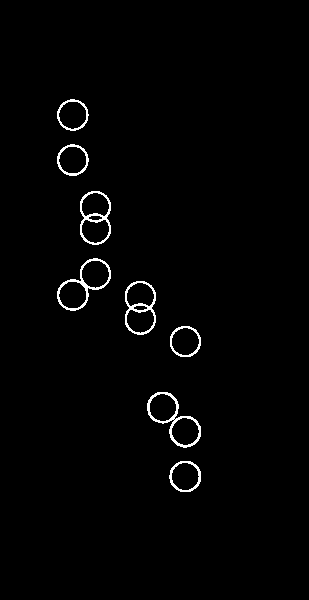

In [105]:
# Verify that it works!
binarize("ZACHE SOCH 2_7A.png")

<hr>
<h4> <b style="color: #00d100">Step 2: </b><b>Identify Circles by Applying Masks</b></h4>
We will apply a series of circular masks to each region where a hold can appear. Fortuantely, the holds are equally spaced both vertically and horizontally. We therefore need to manually label pixel positions of the first row and first column of bolts where holds may be screwed, and simply take all combinations of those indicies. Furthermore, we must define a function to return the "degree to which the region contains a circle". This is not a trivial task, for example...  
<br>
<img src="../resources/options2.png" width="1255" height="500" style="align:left">  


represents the most common possible observations by cropping a 30x30 window around each potential climbing hold location, plotted as a single white dot in the image. Notice that some of these are circles, others are not. We must devise a method of determining which are circles, and which arent.

<h4> <b> The Method </b> </h4>
Apply a circular mask to the obtained 30x30 cropping. Count the number of overlapping instances. If the number of instances is sufficiently large, we deduce that the cropping must contain a circle. Unfortunately, the circles are all slightly offset from one another. Therefore, we need to detect the similarity of a cropping with an small set of known circles, rather than simply a single circle. If the cropping is sufficiently similar to any of the known circles in the set, we deduce the cropping contains a circle. The <b><i>circleness()</i></b> function computes the similarity of a cropping to the set of known circles. It returns the set of highest similarity.


In [104]:
def circleness(candidate):
    """ Determines the ``circleness`` of a provided picture. Compares the provided cropped pic to each circle in the 
        ../resources/circles directory, and returns the percentage of white pixel similarity
    """
    circles = os.listdir('../resources/Circles')
    if '.DS_Store' in circles:
        circles.pop(circles.index('.DS_Store'))

    best_found  = 0
    for circpath in circles:
        circle = (np.array(Image.open(f'../resources/Circles/{circpath}')))
        whites_in_circ = np.sum(circle == 255)
        mutual_whites = np.logical_and(np.array(candidate) == 255, circle)
        match_percent = np.sum(mutual_whites) / whites_in_circ
        if match_percent > best_found:
            best_found = match_percent
    return best_found

In [109]:
def extract_single_route(route, benchs=False, showCircles=False):
    # The width of each window in the binary image
    window_width = 34
    #       A   B   C   D    E    F    G    H    I    J    K 
    lets = [50, 72, 95, 118, 140, 162, 185, 207, 229, 252, 274]
    #       18   17   16   15   14   13   12   11   10   9    8    7    6    5    4    3    2    1  
    nums = [116, 138, 160, 183, 206, 228, 251, 273, 296, 319, 341, 364, 386, 408, 431, 454, 476, 499]
    
    # get the binary version of our image
    binary_pic = binarize(route, benchs)
    holds = []
    for let_dex in range(len(lets)):
        for num_dex in range(len(nums)):
            letter = lets[let_dex]
            number = nums[num_dex]
            # crop the 30 by 30 region around the (letter,number) pixel location
            subpic = binary_pic.crop((letter-window_width//2, number-window_width//2, letter+window_width//2, number+window_width//2 ))

            # if it is more than a 40% match with any of our representative circles, its a match!
            if (circleness(subpic)) > 0.4:
                holds.append(chr(ord('A') + let_dex) + str(18 - num_dex))  
                if showCircles:
                    subpic.show()
    return holds
    






<h4> <b style="color: #00d100">Step 3: </b><b>Lets See If It Works!</b></h4>
Go ahead an manually compare the Image, along with the set of holds identified by the algorithm.. It MATCHES!
<hr>

['E18', 'F10', 'I14', 'I6', 'J9', 'J6']


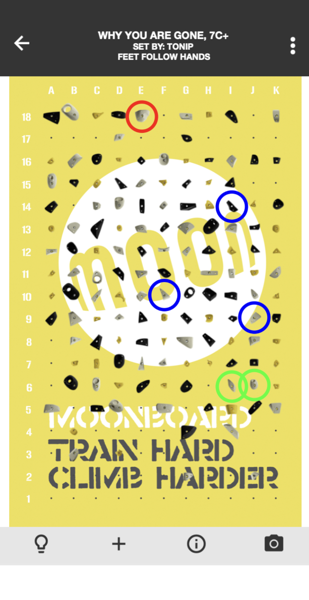

In [110]:
print(extract_single_route("WHY YOU ARE GONE_7C+.png", False, False))
Image.open("../data/RoutePics/User/WHY YOU ARE GONE_7C+.png")
# 

<h4> <b style="color: #00d100">Step 4: </b><b>Apply the Algorithm To Each Route in The Image Set</b></h4>


In [116]:
def extract_moves(directory):
    # All the image names in the directory!
    routes = os.listdir(f'../data/RoutePics/{directory}/')
    # Remove Mac's Pesky .DS_Store File
    if '.DS_Store' in routes:
        routes.pop(routes.index('.DS_Store'))
    # Intialize a structure to store all the route information
    parsed_data = []
    # Traverse the route names in the route set
    iter = 1
    for route in routes:
        print(iter)
        iter +=1
        # Call the route extraction function for each route
        parsed_data.append((route, extract_single_route(route, benchs=directory=='Bench', showCircles=False)))
        
    return parsed_data


<h4> <b style="color: #00d100">Step 5: </b><b>Validate That Our Route Extraction Algorithm Works</b></h4>
Remember the benchmark route data that we obtained by webscraping? It contains the <b>TRUE</b> set of holds corresponding to a set of more than 460 climbing routes. Fortunately, the benchmark routes are also on the MoonBoard application. We can collect a subset of images from the benchmark dataset on the moonboard application, and process the images using the route-extraction pipeline we have just produced. We can compare the route obtained from the algorithm, to the true route obtained from the webscraper. We expect the routes identified by the algorithm to exactly match the route identified by the webscraper.

<h5> <b>Validation Steps</b> </h5>
<ol>
    <li> Run the <i>extract_moves()</i> function for each route in the set of benchmark images.
    <li> Compare the route extracted from the images, to the webscraped route information. Rememeber, we have the name of the route, so we can lookup the moves inside the JSON file obtained earlier.
    <li> Obtain a percentage extraction accuracy. We expect a high value.
</ol>

In [112]:
# Validation Step 1, run the extract_moves() on the set of obtained benchmark images.
parsed_benchdata = extract_moves('Bench')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [114]:
# Validation Step 2 and 3

# load in the JSON set of benchmark problems obtained earlier.
truth_benchdata = json.load(open('../data/bulk_benchmark.json'))
truth_data_dict = {}

# create a dictionary of key-value pairs so we can easily perform lookups.
for bench in truth_benchdata:
    moves = []
    for move in bench["Moves"]:
        moves.append(move['Description'])
    truth_data_dict[bench['Name']] =  [bench['Grade'], moves]

# count how many times the image-to-text gets it wrong
count_wrong = 0
correct = 0
# Iterate the predictions made by our algorithm
for problem in parsed_benchdata:
    prob_str = problem[0].split('_')
    name = prob_str[0].upper()
    grade = prob_str[1][:-4]
    try:
        expected = truth_data_dict[name][1].sort()
        found = problem[1].sort()
        # Compare the algorithms prediction, to the true route
        if not found == expected:
            print(f'found:{found}\nexpected:{expected}\n\n')
            continue
        # if correct
        correct += 1
    except:
        # if not checkable due to pytesseract getting name wrong
        count_wrong += 1
        continue
# Step 3, print the final accuracy score!
print(f"{100 * (correct / (len(parsed_benchdata) - count_wrong))}% extraction accuracy on the benchmark set")

433
100.0% extraction accuracy on the benchmark set


<h2> <b style="color: #00d100">IT WORKS!!!! </b></h2>
We have devised a method to extract the climbing route, name, and grade from images! 

Now that extraction works, lets extract the data of all ```1235``` obtained climbing routes, and write it to ```JSON```. This could take a while..



In [118]:
# Get the extractor's predictions of all user problems, this might take long to run..
# If you want to run it, go ahead, it takes about 55 minutes. If you don't want to bother with that, run the following cell,
# where I have already written it to JSON for you..
parsed_user_data = extract_moves('User')

# set up an array where the collection of extracted user problems can be aggregated
user_data = []
for route in parsed_user_data:
    prob_str = route[0].split('_')
    name = prob_str[0].upper()
    grade = prob_str[1][:-4]
    # a common mistake
    if "8" in grade and not grade.index('8') == 0:
        grade = grade.replace('8', 'B')

    # write the json object to the collection
    user_data.append({
        'Name':name,
        'Grade':grade,
        'Moves': route[1]
    })
# Lets save the extracted user_data
with open('../data/user_routes.json', 'w') as my_file:
    json.dump(user_data, my_file)



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [142]:
# Load the json file written in the previous cell. This will save you a ton of time..
parsed_user_data = json.load(open("../data/user_routes.json"))


<hr>
<h2> <b>This Marks the End of the Data Collection Phase </b></h2>
<h5> We can now explore the data set that we have collected, before building our classifier. </h5>
<hr>


In [141]:
import seaborn as sns
import matplotlib.pyplot as plt

<h4> <b style="color: #00d100">Visualization 1:</b> <b>What is the route difficulty distribution?</b> </h4>
This is an important consideration for us, because we need to correct any potentially existing data inbalance when building our classifier.

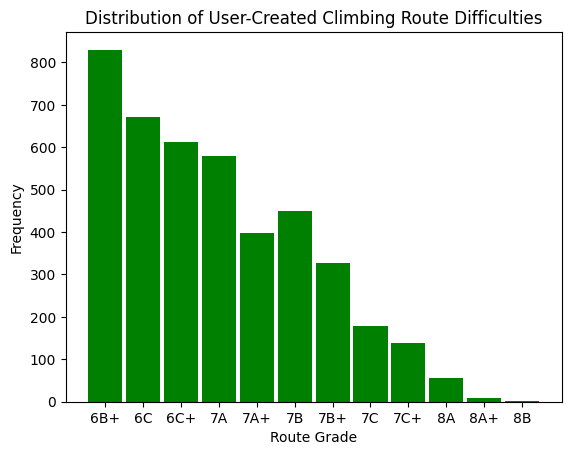

In [143]:
def histo_grades(dataset, title='Climbing Grade Histogram', color='g'):
    # intialize a dictionary of the difficulties
    difficulties = {'6B+':0, '6C':0, '6C+':0, '7A':0, '7A+':0, '7B':0, '7B+':0, '7C':0, '7C+':0, '8A':0, '8A+':0, '8B':0}
    # iterate the routes in the dataset 
    for route in dataset:
        # append the index of the grade
        difficulties[route['Grade']] += 1
    # plot the data
    plt.bar(difficulties.keys(), difficulties.values(), 0.9, color=color)
    plt.xlabel("Route Grade")
    plt.ylabel("Frequency")
    plt.title("Distribution of User-Created Climbing Route Difficulties")

histo_grades(parsed_user_data)

<h4> <b>Clearly This Distribution is Right-Skewed</b> </h4>
Is this trend only reflected in the user-created climbing routes? Is it present in the benchmark dataset as well?

Lets see!



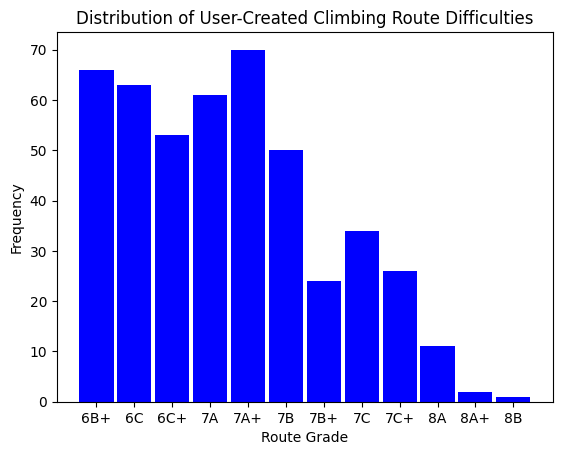

In [144]:
histo_grades(json.load(open('../data/bulk_benchmark.json')), title='Distribution of Benchmark Climbing Route Difficulties', color='b')

<h4> <b style="color: #3030d1" name="finding1">Finding 1:</b> <b>There is an unequal class distribution, the difficult grades are less common</b> </h4>
When we build our classifier, we should take this skewed distribution into account. It is important for the purposes of building our classifier.


<h4> <b style="color: #00d100">Visualization 2:</b> <b>What is the most common climbing hold?</b> </h4>
Out of interest sake, lets attempt to identify the most common climbing holds? 

Based on the previous histograms, it will likely be holds that easy routes tend to utilize, but lets find out!




In [145]:
# allows us to easy dictionary top-n sampling
import heapq


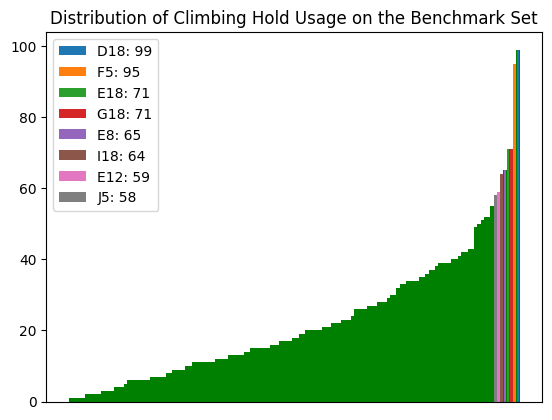

In [147]:
# bench_or_user data is a boolean: True for the benchmark dataset, else false.
def get_holds_dict(bench_or_user):
    # load the benchmark dataset
    dataset = json.load(open('../data/bulk_benchmark.json')) if bench_or_user else json.load(open('../data/user_routes.json'))
    # intialize the set of holds
    holds = [chr(ord('A') + i) + str(j) for j in range(1,19) for i in range(11)]
    # create a dictionary of hold-set
    dict_holds = {}
    for hold in holds:
        dict_holds[hold] = 0
        # iterate the routes in the dataset 
    for route in dataset:
        # iterate the holds in this route
        for hold in route['Moves']:
            # unfortuantely the JSON objects are structured slightly differently
            if bench_or_user:
                dict_holds[hold['Description'].upper()] += 1
            else:
                dict_holds[hold] += 1
    # filter out the top-10 most used
    dict_holds = dict(sorted(dict_holds.items(), key=lambda item: item[1]))
    dict_holds = {x:y for x,y in dict_holds.items() if y!=0}
    return dict_holds

# bench_or_user data is a boolean: True for the benchmark dataset, else false.
def hist_holds(bench_or_user,  title='Climbing Hold-Usage Histogram', color='g'): 
    # get the sorted dictionary of holds
    dict_holds = get_holds_dict(bench_or_user)
    # remove the x-ticks
    plt.xticks([])
    plt.bar(dict_holds.keys(), dict_holds.values(), 1, color='g')
    common_holds = heapq.nlargest(8, dict_holds, key=dict_holds.get)
    for hold in common_holds:
        plt.bar(hold, dict_holds[hold], label=f'{hold}: {dict_holds[hold]}')
    plt.legend()
    plt.title(title)
    return 

hist_holds(True, "Distribution of Climbing Hold Usage on the Benchmark Set", 'g')

<h4> <b> Lets Check the Common Holds on the User-Created Routes </b> </h4>


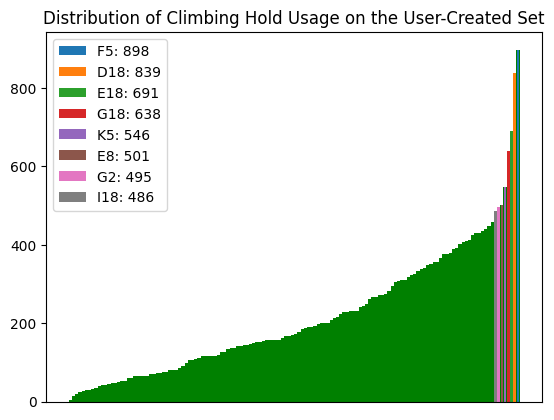

In [148]:
hist_holds(False, "Distribution of Climbing Hold Usage on the User-Created Set", 'b')

<h4> <b style="color: #3030d1">Finding 2:</b> <b>For the most part, the benchmark routes contain the same holds as the user-created routes</b> </h4>
<h4> <b style="color: #00d100">Visualization 3:</b> <b>Where are these holds on the wall?</b> </h4>
<h5> <b>Import Cv2 to Draw Circles Around the Common Holds </b></h5>


In [149]:
import cv2 as cv

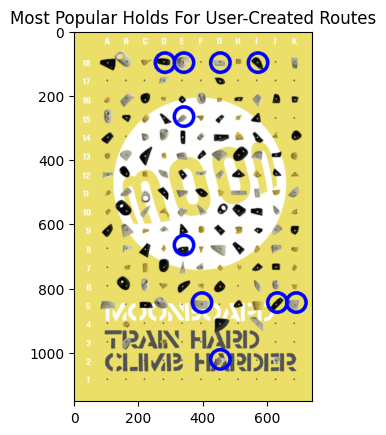

In [150]:
def plot_popular_holds(bench_or_user):
    """ We begin by getting the locations of each hold-bolt in the blank MoonBoard Image """
    #       18   17   16   15   14   13   12   11   10   9    8    7    6    5    4    3    2    1  
    nums = [98, 154, 210, 266, 322, 378, 434, 490, 546, 607, 666, 725, 785, 845, 904, 961, 1022, 1084]
    #       A   B   C   D    E    F    G    H    I    J    K 
    lets = [105, 164, 223, 282, 341, 397, 454, 513, 571, 631, 690]

    # Get the dictionaries containing Hold Usage
    hold_dict = get_holds_dict(bench_or_user)
    hold_dict = heapq.nlargest(10, hold_dict, key=hold_dict.get)

    # initialize blank moonboard images
    hold_dict_pic = cv.cvtColor(cv.imread('../resources/2016board.png'), cv.COLOR_BGR2RGB)


    # for each holds in benchmark set
    for move in hold_dict:
        hold_dict_pic = cv.circle(hold_dict_pic, (lets[ord(move[:1]) - ord('A')], nums[18 - int(move[1:])]), 30, (0,255,0) if bench_or_user else (0,0,255), 10)
    
    # Show the Results
    plt.imshow(hold_dict_pic)
    plt.title(f"Most Popular Holds For {'Benchmark' if bench_or_user else 'User-Created'} Routes")

plot_popular_holds(False)



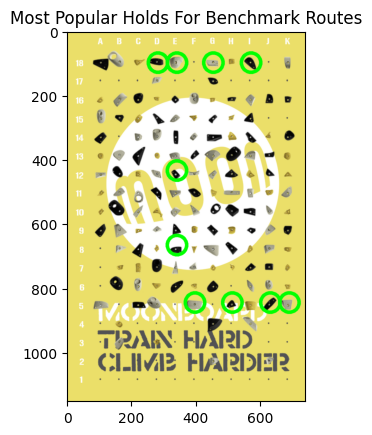

In [151]:
# Visualize the placement of the commonly used holds on the User-Created Problems
plot_popular_holds(True)


<h4> <b style="color: #3030d1">Finding 3:</b> <b>Clearly the community likes the same finishing holds!</b> </h4>
Both the benchmark problems and the user-created routes finish on the same holds most commonly!

<hr>
<h2> <b> Armed With This Insight, Lets Train a Model</b> </h2>
<hr>

<h3> Deciding On the Model </h3>
It is important to carefully consider exactly which type of classification model we decide to implement. Other than simply being a MoonBoard route classifier, this project has another direct application: Automatic Troll Filteration. Unfortunately, sometimes members of the climbing community upload routes which are severly under or over graded. These routes are difficult to remove from the application's system, as their detection relies on feedback from members of the climbing community. It would be interesting if we could use this project to automatically detect severly misgraded routes. In this regard, we care about <b><i>Top N-Accuracy</i></b> <br>



<blockquote>
<p style="color: #d1a807"><b>Top-N Accuracy:</b></p>
Top-N Accuracy corresponds to the percentage frequency that the correct classification is one of the model's top <b>N</b> predictions. For example, top-3 accuracy corresponds to the percentage frequency that one of the models top 3 choices corresponds to the correct classification.
</blockquote>


This metric is useful for automatic troll detection because we can simply deny a user to create a route if it is more than a predefined <b> N </b> grades from our model's predicition. Unfortunately, if we want our model to provide a list of classifications, and the corresponding confidence values, we are limited in our choice of models.


<a href="https://towardsdatascience.com/ensemble-methods-in-machine-learning-what-are-they-and-why-use-them-68ec3f9fef5f"> Ensemble </a> models provide an attractive choice, due to their incredible robustness and classification ability. Unfortunately, they are extremely computationally expensive to tune. The motivation for using ensemble models is to reduce the generalization error of the prediction. As long as the base models are diverse and independent, the prediction error decreases when the ensemble approach is used. For the purpose of this project, we implement a homogenous ensemble of decision trees, using bootstrap aggregation (bagging). It has been shown that a heterogeneous ensemble of diverse classifiers can yield superiour results to a homogenous ensemble, although as a proof-of-concept, we opt to use a slightly simpler homogenous ensemble.
<h4> <b> Lets Import the Libraries</b> </hr>

In [152]:
# A RandomForest Implementation provided by SKlearn
from sklearn.tree import DecisionTreeClassifier

# Bagging Classifier, a method of ensuring diversity in a homogenous ensemble of classifiers
from sklearn.ensemble import BaggingClassifier

# A useful metric to visually evaluate our model's performance
from sklearn.metrics import confusion_matrix

# Seaborn is a visualization library
import seaborn as sns
# Matplotlib is a visualization library
import matplotlib.pyplot as plt



<h4> <b>Vectorize Both Our Benchmark and User-Created Datasets</b> </h4>
Machine Learning algorithms often require the raw data be encoded in a way that is more understandable for the model. In the context of Neural Networks, we need to devise a scheme to convert a candidate climbing route into a 1-dimensional vector, of predefined size. A trivial method would be to simply unstring the MoonBoard into a vector of holds. This vector will contain a 0 if the hold does not form part of the route, and a 1 if the hold does. This scheme implies our input vector is dimension (18*11)x1. Most machine learning algorithms suffer from the <a href="https://en.wikipedia.org/wiki/Curse_of_dimensionality"> Curse of Dimensionality </a>, and would benefit from the application of a dimension reduction scheme like <a href="https://en.wikipedia.org/wiki/Principal_component_analysis"> Principal Component Analysis </a>. Once more, these schemes are too specialized for this implementation. They may yield superiour results, but can always be implemented and explored at a later stage. For now, we use the simple "unstring and encode" method. The target vector contains only zeroes, with a 1 in the index of the marked difficulty.

In [153]:
def to_X_y(route_data, bench_or_user=True):
    """ This method accepts a single JSON object, and converts it to X, y form.
        The X vector contains a binarized representation of the features (holds).
        The y vector contains a binarized representation of the target (grade).

        When Bench_or_user is true, it is assumed the provided datapoint comes from the benchmark dataset. 
        Remember- the JSON sets have a slightly different structure, so this distinction is important
    """
    # This is the shape of the target vector
    grades = ['6B+', '6C', '6C+', '7A', '7A+', '7B', '7B+', '7C', '7C+', '8A', '8A+', '8B']

    # Generate the target vector for this route, y
    y = [0] * len(grades)
    y[grades.index(route_data['Grade'])] = 1
    
    # Empty route vector, X
    X = [0] * (11 * 18)

    # Loop through the moves of the route
    for move in route_data['Moves']:
        # Get the hold
        hold = move['Description'] if bench_or_user else move
        # Deduce the index of this hold in the route vector
        letter_index = ord(hold[0]) - ord('A')
        num_index = int(hold[1:]) - 1
        hold_index = (num_index * 11) + letter_index
        # Turn that bit on
        X[hold_index] = 1

    # Return training point
    return X, y


<h4> <b> Apply the to_X_y() Method to Each Datapoint and Write the Results to JSON </b> </h4>

In [154]:
def encode_all(bench_or_user):
    # There are VERY few routes more difficult that 7C+, we should drop these until more data gets collected.
    grades = ['6B+', '6C', '6C+', '7A', '7A+', '7B', '7B+', '7C', '7C+']

    # intialize a collection to store the encoded datapoints
    encoded_data = []

    # load the data
    routes = json.load(open('../data/bulk_benchmark.json')) if bench_or_user else json.load(open('../data/user_routes.json'))
    # iterate through every route
    for route in routes:
        # Get the encodings
        X, y = to_X_y(route, bench_or_user)
        # convert to JSON form
        if y.index(1) < 9:
            encoded_datapoint = {
                'X': X,
                'y': y
            }
            # add to the collection
            encoded_data.append(encoded_datapoint)

    # Write the encoded dataset to a file for our classifier to use
    with open(f'../data/{"encoded_benchmark.json" if bench_or_user else "encoded_routes.json"}', 'w') as my_file:
        json.dump(encoded_data, my_file)


In [155]:
# lets encode both files, they are written to ../data/encoded_*.json
encode_all(True)
encode_all(False)


<h4> <b> Lets Tune the Ensemeble Using SKLEARN's GridSearch Functionality </b> </h4>
Tuning involves finding a desirable set of hyperparameter configurations. Gridsearching involves the training of a classifier using permutations from a discrete set of hyperparameter alternatives. The grid search takes approximately 47 minutes to execute, but feel free to do so by running the proceeding code block.

In [174]:
from sklearn import model_selection

def do_grid_search():
    """
    {'base_estimator__criterion': 'log_loss', 'base_estimator__max_depth': 5, 'base_estimator__splitter': 'random', 'bootstrap': True, 'max_samples': 0.5, 'n_estimators': 50}
    """
    # load the dataset
    dataset_train = json.load(open('../data/encoded_routes.json'))
    # seperate the feature and target vectors
    Xs = [datapoint['X'] for datapoint in dataset_train]
    ys = [datapoint['y'].index(1) for datapoint in dataset_train]
    # set up the fixed set of hyperparameter alternatives
    param_grid = {
        'base_estimator__max_depth' : [1, 3, 5, 10, None],
        'base_estimator__criterion': ['gini', 'entropy', 'log_loss'],
        'base_estimator__splitter': ['best', 'random'],
        'max_samples' : [0.1, 0.25, 0.5, 0.75, 1],
        'max_features': [0.1, 0.25, 0.5, 0.75, 1],
        'n_estimators': [10, 50, 100],
        'bootstrap': [True, False]
    }
    # use Kfold crossvalidation for a better generalizable estimation
    kfold = model_selection.KFold(n_splits=10, shuffle=True)

    # set up the model
    clf = model_selection.GridSearchCV(
        BaggingClassifier(DecisionTreeClassifier()), 
                    param_grid, cv=kfold, verbose=1)   
    # fit the model             
    clf.fit(Xs, ys)
    # show the results.
    print(clf.cv_results_)
    print(clf.best_params_)
    
do_grid_search()

Fitting 10 folds for each of 4500 candidates, totalling 45000 fits
[CV 1/10] END base_estimator__criterion=gini, base_estimator__max_depth=1, base_estimator__splitter=best, bootstrap=True, max_features=0.1, max_samples=0.1, n_estimators=10;, score=0.193 total time=   0.0s
[CV 2/10] END base_estimator__criterion=gini, base_estimator__max_depth=1, base_estimator__splitter=best, bootstrap=True, max_features=0.1, max_samples=0.1, n_estimators=10;, score=0.186 total time=   0.0s
[CV 3/10] END base_estimator__criterion=gini, base_estimator__max_depth=1, base_estimator__splitter=best, bootstrap=True, max_features=0.1, max_samples=0.1, n_estimators=10;, score=0.191 total time=   0.0s
[CV 4/10] END base_estimator__criterion=gini, base_estimator__max_depth=1, base_estimator__splitter=best, bootstrap=True, max_features=0.1, max_samples=0.1, n_estimators=10;, score=0.215 total time=   0.0s
[CV 5/10] END base_estimator__criterion=gini, base_estimator__max_depth=1, base_estimator__splitter=best, boo

KeyboardInterrupt: 

<h4> <b> Addressing the Skewness in Class Distributions</b> </h4>
Recall that <a href="" style="color:blue"> Finding 1 </a> revealed a large skew in the class distribution of our MoonBoard route dataset. If we do not address this problem, our classifier will be bias towards making predictions corresponding to the majority class.

Forunately, there are methods available to help mitigate this issue. For an ensemble of decision trees, we must implement a sampling method to help correct this problem.

<a href="https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#:~:text=The%20most%20common%20technique%20is,%2C%20for%20simplicity%2C%20are%20continuous." >Synthetic Minority Oversampling Technique </a> (SMOTE) is a statistical technique for increasing the number of datapoints in your dataset, in effort to balance the class distribution of the set. The component works by generating new instances from existing minority classes, and adding them to the training dataset.

In [157]:
# Lets Import the SMOTE module from imbalanced learn
from imblearn.over_sampling import SMOTE


In [158]:
# Load the encoded dataset
dataset_train = json.load(open('../data/encoded_routes.json'))

# aggregate the Xs and ys together, all training points and labels are grouped
Xs = [datapoint['X'] for datapoint in dataset_train]
ys = [datapoint['y'].index(1) for datapoint in dataset_train]

# apply SMOTE
oversample = SMOTE()
Xs, ys = oversample.fit_resample(Xs, ys)

<h4> <b> Class Imbalance is Addressed, Hyperparameters are Identified, Lets Build a Classifier!</b> </h4>


39.3% Accuracy On The Benchmark Set


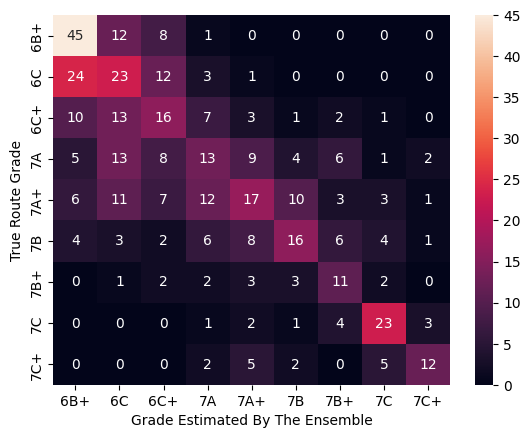

In [173]:
# Load the encoded test dataset!
dataset_test = json.load(open('../data/encoded_benchmark.json'))

# aggregate the Xs and ys together, all training points and labels are grouped
Xs_test = [datapoint['X'] for datapoint in dataset_test]
ys_test = [datapoint['y'].index(1) for datapoint in dataset_test]

# train the model using the identified control parameter configurations
cart = DecisionTreeClassifier(criterion='gini', max_depth=None, splitter='random')
model = BaggingClassifier(base_estimator=cart, n_estimators=50, bootstrap=False, max_samples=0.25, max_features=0.5)
model.fit(Xs, ys)

print(str(100 * model.score(Xs_test, ys_test))[:4] + "% Accuracy On The Benchmark Set")
y_pred = model.predict(Xs_test)

# Visualization labels
labels = ['6B+', '6C', '6C+', '7A', '7A+', '7B', '7B+', '7C', '7C+']

# A heatmap representation of the model's predictions compared to correct label
sns.heatmap(confusion_matrix(ys_test, y_pred), xticklabels=labels, yticklabels=labels, annot=True)
plt.xlabel("Grade Estimated By The Ensemble")
plt.ylabel("True Route Grade")
plt.show()

<h4> <b>What Does This Mean?</b> </h4>
A heatmap is a popular visualization technique that graphically displays the predicitions made by a machine learning model, compared to the true target class. If the machine learning model performs perfectly, the main diagonal of the heatmap should contain high values, and all other cells should contain zero.

<h4> <b>Does our Model Work?</b> </h4>
It depends... Clearly Our model does not just randomly guess, it does correctly grade the climbing route more than one-third of the time. Although this accuracy is less than we may have hoped, it can be improved. Notice that our model is quite unsuccessful in predicting routes of the grade 6C+, compared to the neighboring difficulties 6B and 7A. Why might this be? If we view the class distribution of the training set (part of Finding 1), we observe a gap in the occurance of 6C+ routes! It could worthwhile to collect MORE data pertaining to user-created 6C+ problems explicitly, and checking if the problem is reduced.
<img src="../resources/6cless.png" width="400" height="300" style="align:left">


<hr>
<h3> <b style="color:green">Can The Model Be Improved?</b> </h3>
<hr>
Of Course! Like with most machine learning algorithms- the key to success is DATA. Our classifier has demonstrated signs of success, but it is still in the early stages of its development. There is so much more data available, even collecting just 10% of the available data will allow the model to train on more than 4x the data that we used in this project. It may also be extremely valuable to discuss a better way of extracting descriptive informatino from the moves in a climbing route. Rather than simply giving our classifier a 1-hot encoded vector, we can provide statistics about the route, like:  
    <ul>
        <li> The total number of holds in the route.
        <li> The total length of the route (sum of distances between holds).
        <li> The average distance between each move.
        <li> The longest single move on the route.
        <li> The shortest single move on the route.
        <li> The number of difficult holds used on the route (either manual labelling, or analysis similar to Finding 2).
        <li> The number of easy holds used on the route.
        <li> The "sideways-ness" of the route. Routes that traverse directly upwards are easier.
    </ul>

    
To name a few.

<hr>
<h3> <b style="color:green">Opportunity for Future Work</b> </h3>
<hr>
There is much that can be experimented with in order to futher this project. As mentioned above, I hypothesize that the model will be signifcantly improved if effort is invested into a better method of extracting meaningful data from the holds that form part of a climbing route. Furthermore, it may be worthwhile to explore the implementation of a heterogeneous of diverse classifiers, potentially even using a meta-heuristic as an aggregation method. <a href="https://livebook.manning.com/concept/machine-learning/heterogeneous-ensemble"> This Book </a> provides a complete description on how to implement a robust and successful ensemble-based model. Finally, the single most simple action we can implement to further this project is to collect more data. It may be possible to contact the owner of MoonBoard, <a href="https://moonclimbing.com/general-enquiries"> Ben Moon </a> and ask if the user-created route data can be made available for such a project. Otherwise, the automated script provided by this project can always be improved.




